# This is the notebook for separating code and develop the functions to finally be able to transfer it to scripts

In [65]:
%matplotlib inline
import importlib.util
import sys
# import novosparc
spec = importlib.util.spec_from_file_location("novosparc",
                                              "/home/vschuma/PycharmProjects/novosparc/novosparc/__init__.py")
novosparc = importlib.util.module_from_spec(spec)
sys.modules["novosparc"] = novosparc
spec.loader.exec_module(novosparc)
import os
import numpy as np
import pandas as pd
import pickle

import scanpy as sc

import plotly.express as px
import plotly.graph_objects as go
import plotly.tools as tls

# Input:

* `tissue.gw` (from novosparc reconstruction)
* meta data as csv, read in as pd.df(X,1

In [33]:
data_dir = 'data'
meta_ct_path = os.path.join(data_dir, "mouse_brain_meta_ct.csv")
cell_types_raw = pd.read_csv(meta_ct_path)

atlas_dir = 'data'
target_space_path = os.path.join(atlas_dir, '10x_MouseBrain_coordinates.csv')
locations = pd.read_csv(target_space_path, sep=',')
num_locations = locations.shape[0] # coming from the spatial data #
locations_apriori = locations[:num_locations][['xcoord', 'ycoord']].values
locations = locations_apriori

In [23]:
%%time
#read the pickle file
tissue_file = "tissue_gw.pkl"
picklefile_1 = open(tissue_file, 'rb')
#unpickle the dataframe
pckl_matrix = pickle.load(picklefile_1)
#close file
picklefile_1.close()

gw_matrix = pd.DataFrame(pckl_matrix)

tissue_file = "tissue_complete.pkl"
picklefile_2 = open(tissue_file, 'rb')
tissue = pickle.load(picklefile_2)
picklefile_2.close()

CPU times: user 3.03 ms, sys: 372 ms, total: 375 ms
Wall time: 374 ms


In [15]:
print(cell_types_raw.shape)
print(gw_matrix.shape)
print(type(gw_matrix))

(2688, 1)
(2688, 2688)
<class 'pandas.core.frame.DataFrame'>


# onehot encoding/df merging

In [19]:
def merge_meta_gw(gw_matrix, meta_matrix): # checked, add tests
    """
    gw_matrix - pd.DataFrame, from tissue object (tissue.gw)
    meta_matrix - pd.DataFrame, meta data (x,1), row length (cells?) must match gw_matrix
    output: pd.DataFrame with gw matrix and the meta data labels as column names
    """

    # ToDo: Implement Check for matching dimensions

    # use one-hot encoding for meta-data labels
    meta_encode = pd.get_dummies(meta_matrix)
    # get unique lsit of labels
    unque_lbs = list(meta_matrix.iloc[:,0].unique())
    # merge matrixes
    meta_gw_merge = np.dot(gw_matrix.T,meta_encode) # transpose to get locations as rows
    # dataframe with column names
    meta_gw_df = pd.DataFrame(meta_gw_merge, columns = unque_lbs)

    return meta_gw_df

In [ ]:
def meta_to_tissue(list_of_metagw_names, list_of_metagw_df, tissue): # checked,
    """
    list_of_metagw_names - list containing strings of names of meta_gw matrices to be added to the tissue obj, ordering has to match ordering in list_of_metagw_df
    list_of_metagw_df - list containing dataframes to add, ordering has to match ordering in list_of_metagw_df
    tissue - tissue object, output from novosparc.reconstruct
    """

    # ToDo: implement check for matching length of the both lists

    metadata_mapped = dict()

    for df_name in list_of_metagw_names:
        for df in list_of_metagw_df: # this assumes the usage of only a few metadata sets, not really a scalable approach
            metadata_mapped[df_name] = df

    tissue.metadata = metadata_mapped
    print("tissue object modified with set of metadata dataframes")

**Plotting meta data lable specific works further with:**
```
pl_genes =["some", "genes"]
dataset_to_plot = sc.AnnData(tissue.metadata[">>name_of_metadata_label<<"], dtype=float)
dataset_to_plot.obsm['spatial'] = locations
novosparc.pl.embedding(dataset_to_plot, pl_genes)
```

# Dataframes for "hightes mapping prop" plots

In [47]:
def get_highest_prop_lbl(meta_array, plot_anndata): # checked, add tests
    """
    meta_array = pd.Df of meta_gw_merged
    plot_anndata = anndata version of the metadata matrix for plotting (compare w dataset_tissue)
    output: pd.DF, 3 columns: 1)mapping_prop_lbl - mapping probability value for the label at the location,
                          2)mapped_lbl_idx - column number index of the label in the meta_gw_merge matrix,
                          3)mapped_lbl - label name
    """
    # ToDo: check if meta_array is a float array with string value column names

    # find max value in the row
    out_array = np.amax(np.array(meta_array), axis=1)
    # find the values column name - get the index
    out_array = np.vstack((out_array, np.argmax(np.array(meta_array), axis=1)))
    # transform to df to enable multiple data types
    out_df = pd.DataFrame(out_array.T)
    # write value and column name into the new df
    # can I add a new column like this? - yes, but it takes already quite some time
    # ToDo: Implement speed up versions Enes wrote to you
    out_df[2] = out_df[1].apply(lambda x: meta_array.columns[x])
    out_df.columns = ["mapping_prop_lbl", "mapped_lbl_idx", "mapped_lbl"]

    # add annotation to the dataset anndata
    for col in out_df.columns:
        plot_anndata.obsm[col] = out_df[col].to_numpy().reshape(-1,1)
    print(f"updated anndata objc by adding {out_df.columns} as obsm")

    return out_df

# Highest Probability Plots

In [7]:
def plot_high_prop_label_no_opac(plot_anndata,width=1000,height=800,plot_bgcolor="black",columnname="label"): # checked, add tests
    """
    plot_anndata - anndata version of the metadata matrix for plotting (compare w dataset_tissue) after
    "get_highest_prop_lbl" processing
    """

    # ToDo: Implement check for existence of "mapped_lbl" property
    # ToDo: maybe also check if only expected input was given
    # ToDo: add option for plot title

    # set coordinates
    xy = plot_anndata.obsm['spatial']
    x = xy[:, 1]
    y = xy[:, 0] if xy.shape[1] > 1 else np.ones_like(x)

    # set values
    values = plot_anndata.obsm["mapped_lbl"]
    plot_df = pd.DataFrame(values, columns=[columnname])

    # set figure
    fig = px.scatter(plot_df, x=x, y=y, color=columnname,
                 width=width, height=height)
    fig.update_xaxes(showgrid=False, zeroline=False)
    fig.update_yaxes(showgrid=False, zeroline=False)
    fig.update_layout(plot_bgcolor=plot_bgcolor)
    # ToDo: add color palette option (especially important when doing plots for multiple metadata sets)
    fig.show()

    return fig

In [8]:
def flatten(l):
     return [item for sublist in l for item in sublist]

def labels_to_legend(plot_anndata, out_df, labelname = "label"):
    """
    todo
    output:
        lbl_mtching: dict [label index : lable string]
        lbl_idx: pd.Series, as many rows as location, index per location
    """

    # ToDo: Implement check for assumptions (e.g. "mapped_lbl")

    # labels as discrete colors with strings as label
    meta_labels = plot_anndata.obsm["mapped_lbl"]
    lbl_idx = out_df["mapped_lbl_idx"]
    plot_df = pd.DataFrame({labelname : plot_anndata.obsm["mapped_lbl"].tolist(),
                            "lbl_idx": plot_anndata.obsm["mapped_lbl_idx"].tolist()
                             })
    # get labels as string list
    lbl_str = flatten(plot_df[labelname])
    # match the lable string wiht their index number (for legend)
    lbl_mtchng = {k:str(v) for k,v in zip(tuple(lbl_idx), tuple(lbl_str))}

    return lbl_mtchng, lbl_idx

def plot_high_prop_label_var_opac_2(plot_anndata, out_df, lbl_idx, lbl_mtchng, labelname = "label",
                                    width=1000,height=800):
    """
    todo
    """

    # ToDo: checks for assumptions and naming conventions
    # ToDo: add option for plot title
    # plot frame
    xy = plot_anndata.obsm['spatial']
    x = xy[:, 1]
    df = pd.DataFrame({'x_lv': xy[:, 1],
                   'y_lv': xy[:, 0] if xy.shape[1] > 1 else np.ones_like(x),
                   'color': lbl_idx,
                   'alpha': out_df["mapping_prop_lbl"]
                   })

    # color legend
    clrs_dscrt = px.colors.qualitative.Alphabet[:len(df['color'].unique())]
    idx_clr = {idx:str(clr) for idx,clr in zip(df['color'].unique(),set(clrs_dscrt))}

    # plot
    fig = go.Figure()
    fig.update_xaxes(showgrid=False, zeroline=False)
    fig.update_yaxes(showgrid=False, zeroline=False)

    fig.layout.height = height
    fig.layout.width = width

    for c in df['color'].unique():
        df_color = df[df['color'] == c]
        # normalize alpha values
        alpha_raw = df_color['alpha'].to_numpy().reshape(-1,1)
        alpha_norm = (alpha_raw - alpha_raw.min()) / (alpha_raw.max() - alpha_raw.min())
        # plot label color
        fig.add_trace(
         go.Scatter(
             x=df_color['x_lv'],
             y=df_color['y_lv'],
             name=lbl_mtchng[c],
             mode="markers",
             # text = out_df[\ mapped_ct\ ], # todo this could be an array of joint string with cell type + probability,
             showlegend=True,
             marker=go.scatter.Marker(
                 color=idx_clr[c],
                 size=11,
                 opacity=alpha_norm ) # I think this has to be another column in that dataframe then
             ))
        fig.update_layout(legend=dict(
                 bordercolor = idx_clr[c]))
    fig.show()
    return fig

# Saving Plots as HTML


In [73]:
def save_plots_to_html(list_of_plots, filename='plotly_graphs.html', full_html=False, include_plotlyjs='cdn'):
    '''
    list of plots - list of plots in plotly format (convert mpl plots with tls.mpl_to_plotly(plot) first)
    '''
    # Todo: check format assumptions
    with open(filename, 'a') as f:
        for plot in list_of_plots:
            f.write(plot.to_html(full_html=full_html, include_plotlyjs=include_plotlyjs))
    print(f"successfully saved plots to {filename}")

# Test Functions

In [36]:
ct_mtrx = merge_meta_gw(gw_matrix, cell_types_raw)
type(ct_mtrx)
ct_mtrx[:2]

,Cortex_2,Cortex_5,Thalamus_2,Hypothalamus_2,Cortex_4,Fiber_tract,Lateral_ventricle,Cortex_1,Hypothalamus_1,Striatum,Hippocampus,Pyramidal_layer,Thalamus_1,Cortex_3,Pyramidal_layer_dentate_gyrus
0,0.000009,0.000318,0.000006,0.000007,0.000002,6.193560e-07,0.000002,2.383749e-06,8.996939e-07,0.000003,0.000001,0.000005,7.730645e-06,0.000003,5.109071e-06
1,0.000004,0.000001,0.000002,0.000002,0.000325,3.402918e-07,0.000005,1.842629e-07,2.015233e-07,0.000012,0.000012,0.000003,4.812059e-07,0.000005,4.206201e-07


In [31]:
print(tissue.__dir__())
meta_to_tissue(['cell types'],[ct_mtrx],tissue)
print(tissue.__dir__())

['dataset', 'dge', 'locations', 'num_cells', 'num_locations', 'gene_names', 'num_genes', 'atlas_matrix', 'markers_to_use', 'output_folder', 'num_markers', 'costs', 'gw', 'sdge', 'spatially_informative_genes', 'p_expression', 'p_locations', 'cleaned_dge', 'alpha_linear', 'epsilon', '__module__', '__doc__', '__init__', 'setup_smooth_costs', 'setup_linear_cost', 'setup_reconstruction', 'reconstruct', 'calculate_sdge_for_all_genes', 'calculate_spatially_informative_genes', 'cleaning_expression_data', '__dict__', '__weakref__', '__repr__', '__hash__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__new__', '__reduce_ex__', '__reduce__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']
tissue object modified with set of metadata dataframes
['dataset', 'dge', 'locations', 'num_cells', 'num_locations', 'gene_names', 'num_genes', 'atlas_matrix', 'markers_to_use', 'output_folde

## For plotting
### preparing anndata object for plotting

In [44]:
pl_genes =["Hypothalamus_2", "Striatum"]
dataset_to_plot = sc.AnnData(tissue.metadata["cell types"], dtype=float)
dataset_to_plot.obsm['spatial'] = locations
dataset_to_plot.obsm

/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AxisArrays with keys: spatial

In [45]:
high_prop_lbls = get_highest_prop_lbl(ct_mtrx, dataset_to_plot)
print(type(high_prop_lbls))

<ipython-input-6-aa0761fe1323>:15: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  out_df[2] = out_df[1].apply(lambda x: meta_array.columns[x])


<class 'pandas.core.frame.DataFrame'>


AnnData object with n_obs × n_vars = 2688 × 15
    obsm: 'spatial', 'mapping_prop_lbl', 'mapped_lbl_idx', 'mapped_lbl'

In [46]:
print(dataset_to_plot.obsm)
print(high_prop_lbls)

AxisArrays with keys: spatial, mapping_prop_lbl, mapped_lbl_idx, mapped_lbl
      mapping_prop_lbl  mapped_lbl_idx                     mapped_lbl
0             0.000318             1.0                       Cortex_5
1             0.000325             4.0                       Cortex_4
2             0.000309            14.0  Pyramidal_layer_dentate_gyrus
3             0.000328             4.0                       Cortex_4
4             0.000249            14.0  Pyramidal_layer_dentate_gyrus
...                ...             ...                            ...
2683          0.000324             9.0                       Striatum
2684          0.000180             7.0                       Cortex_1
2685          0.000325             7.0                       Cortex_1
2686          0.000232            14.0  Pyramidal_layer_dentate_gyrus
2687          0.000159             3.0                 Hypothalamus_2

[2688 rows x 3 columns]


In [75]:
plot1 = plot_high_prop_label_no_opac(dataset_to_plot)

In [49]:
# creating legend
lbl_mtching, lbl_idx = labels_to_legend(dataset_to_plot, high_prop_lbls)

In [50]:
lbl_mtching

{1.0: 'Cortex_5',
 4.0: 'Cortex_4',
 14.0: 'Pyramidal_layer_dentate_gyrus',
 8.0: 'Hypothalamus_1',
 3.0: 'Hypothalamus_2',
 5.0: 'Fiber_tract',
 9.0: 'Striatum',
 0.0: 'Cortex_2',
 7.0: 'Cortex_1',
 12.0: 'Thalamus_1',
 6.0: 'Lateral_ventricle',
 13.0: 'Cortex_3',
 2.0: 'Thalamus_2',
 11.0: 'Pyramidal_layer',
 10.0: 'Hippocampus'}

In [52]:
type(lbl_idx)

pandas.core.series.Series

In [55]:
plot2 = plot_high_prop_label_var_opac_2(dataset_to_plot, high_prop_lbls, lbl_idx, lbl_mtching)

In [62]:
import matplotlib.pyplot as plt
def embedding(dataset, color, title=None, colorbarlabel = 'probability or UMI count', size_x=None, size_y=None,
              pt_size=10, tit_size=15, dpi=100):
    """
    Plots fields (color) of Scanpy AnnData object on spatial coordinates
    dataset -- Scanpy AnnData with 'spatial' matrix in obsm containing the spatial coordinates of the tissue
    color -- a list of fields - gene names or columns from obs to use for color
    """

    # set plotting frame with number and size of plots
    title = color if title is None else title
    ncolor = len(color)
    per_row = 3 # Fixme: why is this hardcoded anyway? make it dynamic pls
    per_row = ncolor if ncolor < per_row else per_row
    nrows = int(np.ceil(ncolor / per_row))
    size_x = 5 * per_row if size_x is None else size_x # Fixme: this breaks when plotting multiple plots
    size_y = 3 * nrows if size_y is None else size_y # Fixme: see above
    fig, axs = plt.subplots(nrows, per_row, figsize=(size_x, size_y), dpi=dpi)
    xy = dataset.obsm['spatial']
    x = xy[:, 0]
    y = xy[:, 1] if xy.shape[1] > 1 else np.ones_like(x)
    axs = axs.flatten() if type(axs) == np.ndarray else [axs]
    for ax in axs:
        ax.axis('off')

    # plot mapped expression values per gene
    for i, g in enumerate(color):
        if g in dataset.var_names:
            values = dataset[:, g].X
        elif g in dataset.obs.columns:
            values = dataset.obs[g]
        else:
            continue
        im = axs[i].scatter(x, y, c=np.array(values), s=pt_size)
        axs[i].set_title(title[i], size=tit_size)
        fig.colorbar(im, ax=axs[i])

    plt.show()
    plt.tight_layout()
    # fixme: Why doesn't this return anything? You can't do anything with a function like that...cm on....
    print("return another figure object")
    return fig

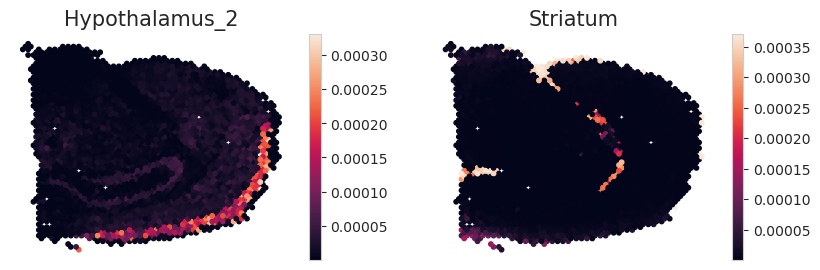

return another figure object


<Figure size 432x288 with 0 Axes>

In [63]:
plot3_mpl = embedding(dataset_to_plot, pl_genes)

In [66]:
plot3 = tls.mpl_to_plotly(plot3_mpl)

/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/plotly/matplotlylib/mplexporter/exporter.py:289: MatplotlibDeprecationWarning:


The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.

/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/plotly/matplotlylib/renderer.py:573: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates



In [76]:
save_plots_to_html([plot1, plot2, plot3])

successfully saved plots to plotly_graphs.html
